# Example

This notebook shows an example code segment from our work published in [*Predicting to Improve: Integrity Measures for Assessing Visual Localization Performance*](https://ieeexplore.ieee.org/document/9830823).

Our supervised learning approach requires a calibration dataset (reference and query set) for training, and a separate dataset (reference and query set) for testing. Ground truth data is required for the calibration set for training, and for the test set to assess performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from vpred_tools import *
from vpred_factors import *

Here, we use feature vectors extracted from the Nordland fall set as our reference set, and from the spring set as our query set.  The calibration and test sets are taken from geographically different sections of the dataset.

Download the example Nordland feature set using the link [here](https://cloudstor.aarnet.edu.au/plus/s/UgpN69h5VP2thG8).

Our example feature vectors have been created by first pre-processing our images by converting to grayscale, downsampling to 64x64, and patch-normalizing, and then using Sum of Absolute Differences (SAD) to form the feature vectors. Examples of our feature vectors are shown below (reshaped as an image).

In [2]:
with np.load('compressed_features.npz') as data:
    features_calref = data['features_calref']
    features_calqry = data['features_calqry']
    features_testref = data['features_testref']
    features_testqry = data['features_testqry']

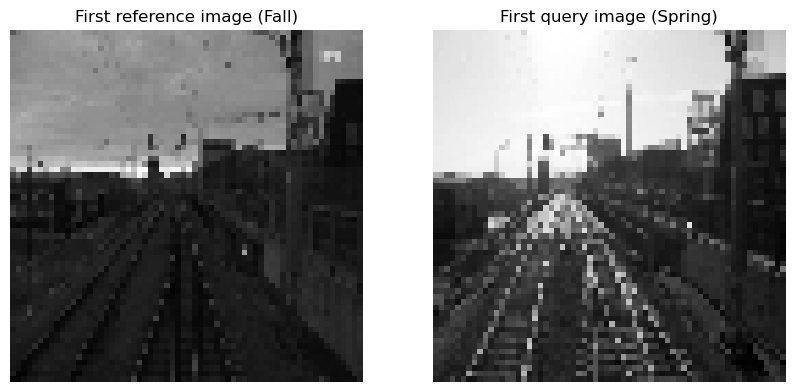

In [3]:
fig,ax=plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(features_calref[0].reshape((64,64)),cmap='gray'); ax[0].axis('off')
ax[1].imshow(features_calqry[0].reshape((64,64)),cmap='gray'); ax[1].axis('off')
ax[0].set_title('First reference image (Fall)'); 
ax[1].set_title('First query image (Spring)');

In this example, the reference and query images are taken at the same locations, so the ground truth match for each query is the reference image with the same index:

In [4]:
# Define ground truth
actual_match_cal=np.arange(0,len(features_calqry))
actual_match=np.arange(0,len(features_testqry))

We create the similarity matrix for the calibration set and test set:

In [5]:
Scal,_,_=create_normalised_similarity_matrix(features_calref,features_calqry)
S,Srefmean,Srefstd=create_normalised_similarity_matrix(features_testref,features_testqry)

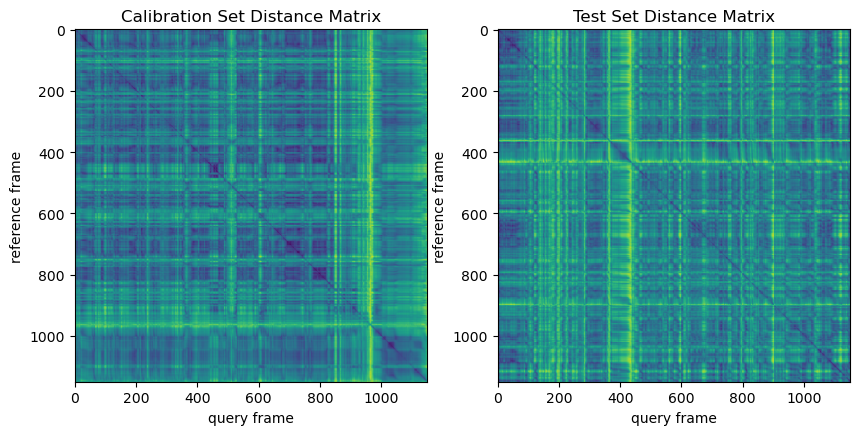

In [6]:
fig,ax=plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(Scal); ax[1].imshow(S);
ax[0].set_title('Calibration Set Distance Matrix'); 
ax[1].set_title('Test Set Distance Matrix');
for axes in ax:
    axes.set_xlabel('query frame'); axes.set_ylabel('reference frame');

## Supervised learning pipeline

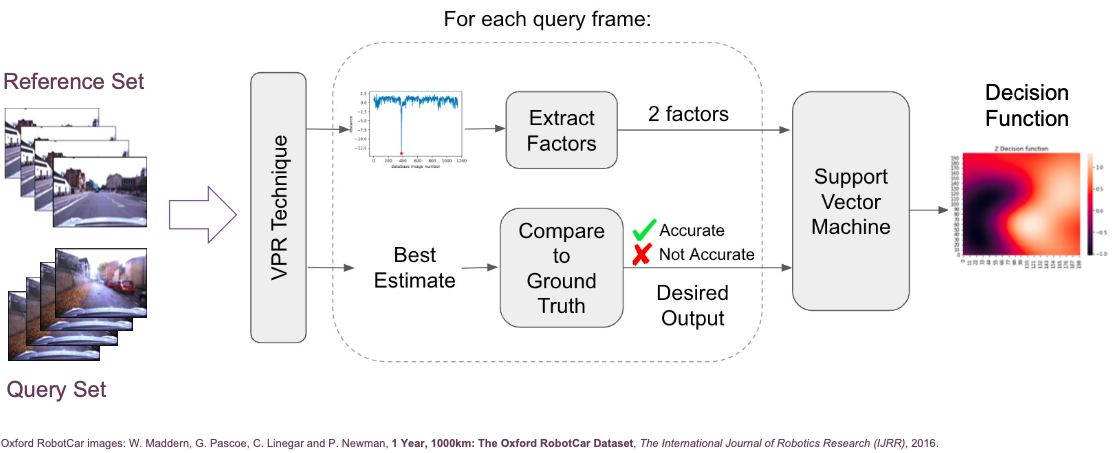

We define the acceptable tolerance for a 'correct' match as +/- one image frame:

In [7]:
tolerance=1

Train the Support Vector Machine using the calibration dataset

In [8]:
# Extract factors that describe the "sharpness" of distance vectors
factor1_cal=find_va_factor(Scal)
factor2_cal=find_grad_factor(Scal)
factors = ['VA ratio','Average Gradient'] # for axis labels when plotting
# Form input vector
Xcal=np.c_[factor1_cal,factor2_cal]
scaler = StandardScaler()
Xcal_scaled = scaler.fit_transform(Xcal)
# Form desired output vector
y_cal=find_y(Scal,actual_match_cal,tolerance)
# Define and train the Support Vector Machine
model = svm.SVC(kernel='rbf',C=1,gamma='scale',class_weight='balanced')
model.fit(Xcal_scaled,y_cal);
# Make predictions on calibration set to assess performance
y_pred_cal = model.predict(Xcal_scaled)
y_zvalues_cal = model.decision_function(Xcal_scaled)
print('Performance of prediction on Calibration set: ')
find_prediction_performance_metrics(y_pred_cal,y_cal,verbose=True);

Performance of prediction on Calibration set: 
TP=461, TN=357, FP=57, FN=275
precision=89.0%  recall=62.6%



## Make predictions on test set

In [9]:
# Extract factors from similarity matrix on test set
factor1=find_va_factor(S)
factor2=find_grad_factor(S)
# Form SVM input vector
X=np.c_[factor1,factor2]
X_scaled=scaler.transform(X)
# Make predictions
y_zvalues = model.decision_function(X_scaled)
y_pred = model.predict(X_scaled)

# Assess performance of prediction on test set
y=find_y(S,actual_match,tolerance) # find acutal performance of test set
print('Performance of prediction on Test set: ')
find_prediction_performance_metrics(y_pred,y,verbose=True);

Performance of prediction on Test set: 
TP=407, TN=341, FP=91, FN=311
precision=81.7%  recall=56.7%



## Assess performance

/Users/carson/repo/test/predict2improve-main/vpred_tools.py:101: RuntimeWarning: invalid value encountered in long_scalars
  precision=num_tp/(num_tp+num_fp)


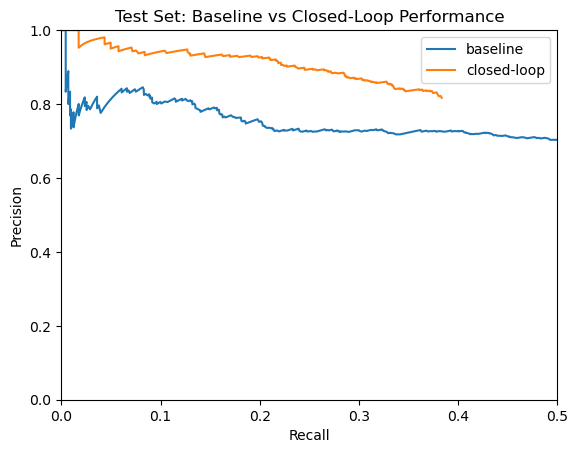

In [10]:
bl_p,bl_r,bl_tp,bl_fp,bl_tn,bl_fn,bl_d=find_baseline_performance_metrics(S,actual_match,tolerance)
cl_p,cl_r,cl_tp,cl_fp,cl_tn,cl_fn,cl_d=find_closedloop_performance_metrics(S,actual_match,tolerance,y_pred)

plot_baseline_vs_closedloop_PRcurves(S,actual_match,tolerance,y_pred)
plt.title('Test Set: Baseline vs Closed-Loop Performance');
plt.xlim([0,0.5]);

We see in this example that the closed-loop prediction system provides an improvement over the baseline VPR technique.